In [11]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings 
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import ast
import seaborn as sns

pd.set_option('display.max_rows', 1000)

In [13]:
df = pd.read_csv("/tmp/inputs/Bank_Customer_Churn_Prediction.csv").drop_duplicates()
print(df.shape)
print(df.sample(5).T)

(10000, 12)


,2660,1478,9837,9695,3232
customer_id,15756241,15630725,15809124,15658675,15814553
credit_score,767,649,750,710,559
country,France,France,France,Germany,France
gender,Female,Female,Male,Male,Female
age,44,45,38,37,34
tenure,2,5,5,6,5
balance,152509.25,92786.66,151532.4,135795.63,68999.66
products_number,1,1,1,1,2
credit_card,1,1,1,0,1
active_member,1,0,1,1,1


In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 1015.6+ KB


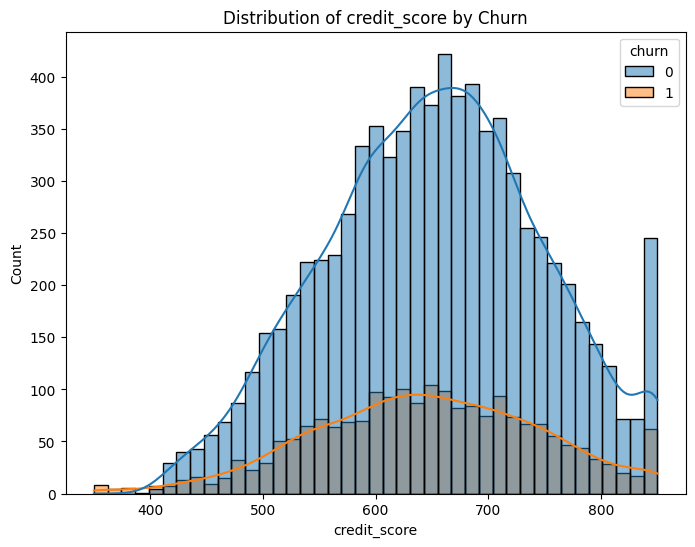

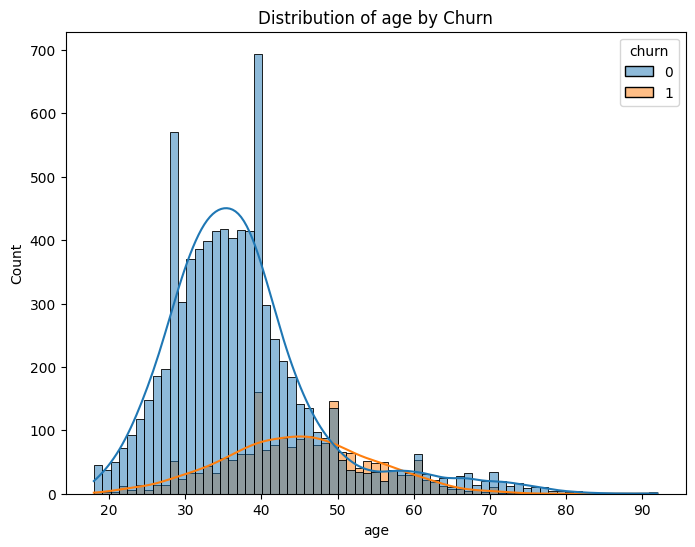

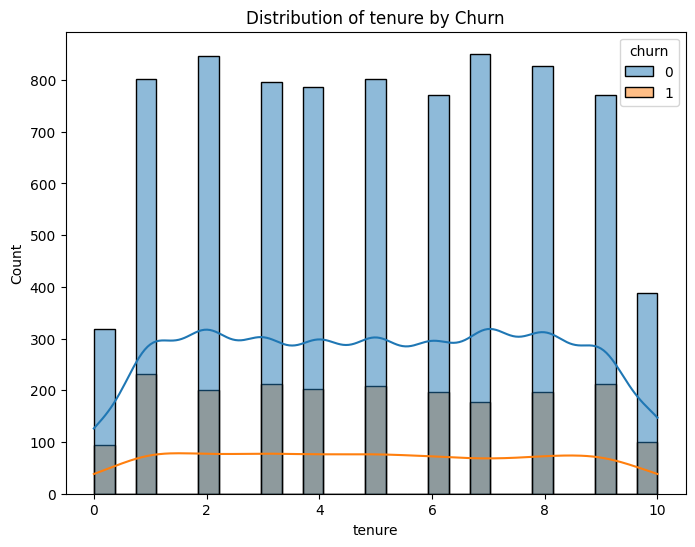

In [16]:
# Visualizing the distributions of numerical features
numerical_features = ["credit_score", "age", "tenure"]
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=feature, hue="churn", kde=True)
    plt.title(f"Distribution of {feature} by Churn")
    plt.show()

<Axes: xlabel='credit_score', ylabel='age'>

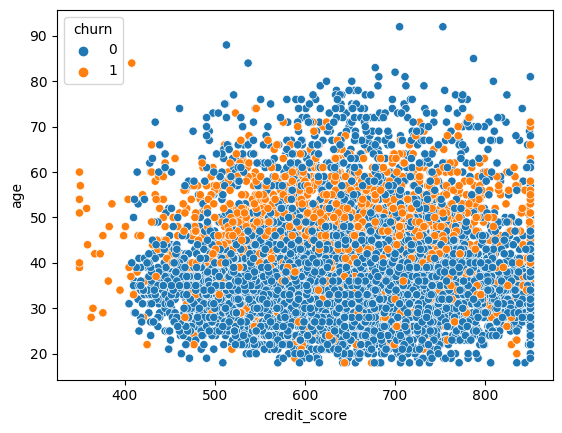

In [15]:
# EDA
sns.scatterplot(x='credit_score', y='age', hue='churn', data=df)

In [5]:
# data transformation
# select label
main_label = 'churn'
# group columns with larger bins
df['credit_score'] = df['credit_score'].apply(lambda x: 25*round(x/25))
df['age'] = df['age'].apply(lambda x: 5*round(x/5))
# log10-transform balance and estimated salary
df['log10_balance'] = df['balance'].apply(lambda x: 1/5*round(5*np.log10(x+1)))
df['log10_estimated_salary'] = df['estimated_salary'].apply(lambda x: 1/2*round(2*np.log10(x)))


# drop unused columns
cols2drop = ['customer_id', 'balance', 'estimated_salary']
df = df.drop(cols2drop, axis=1)
print(df.shape)
print(df.sample(5).T)

(10000, 11)


,4556,9809,2208,1787,9691
credit_score,675,825,725,675,775
country,France,France,France,France,France
gender,Female,Female,Female,Male,Male
age,20,40,45,25,40
tenure,1,1,2,1,4
products_number,1,1,1,1,2
credit_card,1,1,1,0,1
active_member,1,0,0,0,1
churn,0,1,1,1,0
log10_balance,5.0,5.0,5.0,5.2,5.0


In [6]:
# machine learning
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5000, 10), (5000, 10), (5000,), (5000,))

In [7]:
import os

# create and change directory
os.makedirs('/tmp/inputs/catboost_info/', exist_ok=True)
os.chdir('/tmp/inputs/catboost_info/')

# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostClassifier(iterations=500,
                           depth=3,
                           border_count=22,
                           l2_leaf_reg=0.3,
                           learning_rate=4e-2,
                           verbose=0)

#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict_proba(train_pool)[:,1]
y_test_pred = model.predict_proba(test_pool)[:,1]
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"ROC AUC score for train {round(roc_auc_train,4)}, and for test {round(roc_auc_test,4)}")

ROC AUC score for train 0.876, and for test 0.8758


In [8]:
# calculating the baseline ROC AUC score assuming the same probability from training labels to test
roc_auc_baseline = roc_auc_score(y_test, [np.mean(y_train)]*len(y_test))
print(roc_auc_baseline)

# Explanations with SHAP values
ex = shap.TreeExplainer(model)
print(f"Average churn probability is {round(np.mean(y_test),4)}")
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

0.5
